In [ ]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
    ndcg_score,
    roc_curve,
    auc
)
import sys



In [ ]:
MODEL_PATH = "./polyphenol_classifier_final"

# Check for a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
    model.to(device)
except EnvironmentError:
    print(f"ERROR: folder NOT FOUND '{MODEL_PATH}'")
    sys.exit(1)

print("Model loaded.")

Caricamento del modello e del tokenizer da: ./polyphenol_classifier_final
Utilizzo del dispositivo: cpu
Modello e Tokenizer caricati con successo.


In [ ]:
FILE_BENCHMARK = "benchmark.xlsx"

try:

    df = pd.read_excel(FILE_BENCHMARK)


except FileNotFoundError:
    print(f"ERRORE: File '{FILE_BENCHMARK}' not found.")
    sys.exit(1)
except ImportError:
    print("ERROR: library openpyxl is necessary to open the file.")
    print("run: pip install openpyxl")
    sys.exit(1)

if 'abstract' not in df.columns:
    print("ERRORE: Il file benchmark non contiene una colonna chiamata 'abstract'.")
    sys.exit(1)
if 'label' not in df.columns:
    print("ERRORE: Il file benchmark non contiene una colonna chiamata 'label'.")
    sys.exit(1)

df = df.rename(columns={'abstract': 'text'})

df_pulito = df[['text', 'label']]


df_pulito = df_pulito.dropna(subset=['text', 'label'])
df_pulito['label'] = df_pulito['label'].astype(int)


benchmark_dataset = Dataset.from_pandas(df_pulito)

print("\nBenchmark pronto per la valutazione (colonne 'title' ignorate).")
print("Distribuzione etichette nel benchmark:")
print(df_pulito['label'].value_counts(normalize=True))

File 'benchmark.xlsx' caricato. Numero di documenti: 348

Benchmark pronto per la valutazione (colonne 'title' ignorate).
Distribuzione etichette nel benchmark:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)


print("Inizio tokenizzazione del benchmark...")
tokenized_dataset = benchmark_dataset.map(tokenize_function, batched=True)

tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset.set_format("torch")

print("Tokenizzazione completata.")

Inizio tokenizzazione del benchmark...


Map:   0%|          | 0/348 [00:00<?, ? examples/s]

Tokenizzazione completata.


In [ ]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary')
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./eval_results",
    per_device_eval_batch_size=8,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
)

test_results = trainer.evaluate(eval_dataset=tokenized_dataset)

print(f"\nAccuracy on Benchmark: {test_results['eval_accuracy']:.4f}")
print(f"F1-score on Benchmark: {test_results['eval_f1']:.4f}")
print(f"Precision on Benchmark: {test_results['eval_precision']:.4f}")
print(f"Recall on Benchmark: {test_results['eval_recall']:.4f}")

--- 1. VALUTAZIONE SET-BASED (Accuracy, F1, Precision, Recall) ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Accuracy sul Benchmark: 0.9569
F1-score sul Benchmark: 0.9587
Precision sul Benchmark: 0.9206
Recall sul Benchmark: 1.0000


In [ ]:

predictions = trainer.predict(tokenized_dataset)

logits = predictions.predictions
labels = predictions.label_ids


probs = torch.softmax(torch.tensor(logits), dim=1)

relevance_scores = probs[:, 1].numpy()




--- 2. OTTENIMENTO PUNTEGGI PER RANKING E ROC ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Logits e Punteggi di Rilevanza calcolati.


In [ ]:



map_score = average_precision_score(labels, relevance_scores)

def mean_reciprocal_rank(y_true, y_score):
    sorted_indices = np.argsort(-y_score)
    for rank, idx in enumerate(sorted_indices, start=1):
        if y_true[idx] == 1:
            return 1.0 / rank
    return 0.0

mrr_score = mean_reciprocal_rank(labels, relevance_scores)

# Calcola nDCG
ndcg = ndcg_score([labels], [relevance_scores])

print(f"MAP: {map_score:.4f}")
print(f"MRR: {mrr_score:.4f}")
print(f"nDCG: {ndcg:.4f}")


--- 3. VALUTAZIONE RANKING-BASED (MAP, MRR, nDCG) ---
MAP: 0.9998
MRR: 1.0000
nDCG: 1.0000


In [ ]:
import numpy as np

def precision_at_k(y_true, y_score, k):

    if k <= 0:
        return 0.0

    sorted_indices = np.argsort(-np.asarray(y_score))

    sorted_labels = np.asarray(y_true)[sorted_indices]

    top_k_labels = sorted_labels[:k]

    relevant_count = np.sum(top_k_labels)

    return relevant_count / k

def r_precision(y_true, y_score):

    y_true = np.asarray(y_true)

    R = np.sum(y_true)

    if R == 0:
        return 0.0

    # R-Precision is  Precision@R

    return precision_at_k(y_true, y_score, k=int(R))

# --- 4. RANKING-BASED (P@X, R-Precision) ---

# calculate P@5 e P@10
p_at_20 = precision_at_k(labels, relevance_scores, k=20)


print(f"P@20: {p_at_20:.4f}")

# Calculate R-Precision
r_prec = r_precision(labels, relevance_scores)
print(f"R-Precision: {r_prec:.4f}")


--- 4. VALUTAZIONE RANKING-BASED (P@X, R-Precision) ---
P@20: 1.0000
R-Precision: 0.9943



--- 4. CURVA ROC E AREA SOTTESA (AUC) ---
Area Under the Curve (AUC): 0.9998


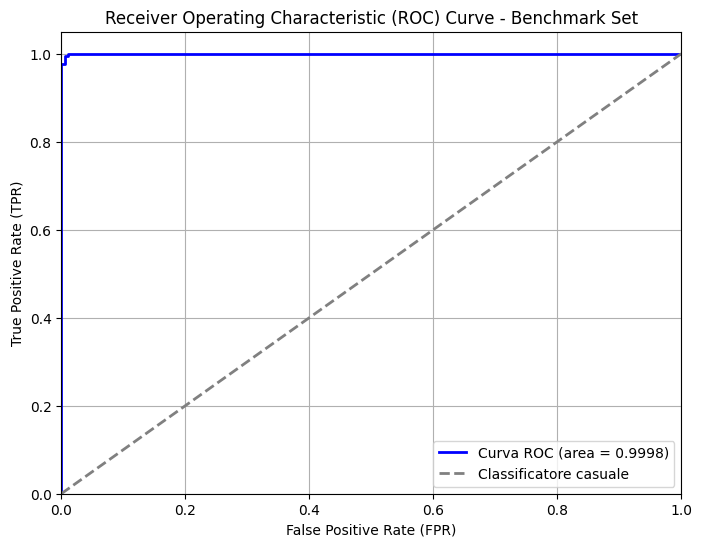

In [ ]:

fpr, tpr, thresholds = roc_curve(labels, relevance_scores)

#  (AUC)
roc_auc = auc(fpr, tpr)

print(f"Area Under the Curve (AUC): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Classificatore casuale')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Benchmark Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()